<a href="https://colab.research.google.com/github/DamodaraBarbosa/bank_customer_churn_prediction/blob/main/bank_customer_churn_prediction_%7C_LGBMCLassifier_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing `category-encoders`

In [2]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.2 MB/s eta 0:00:00


Importing libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Random seed

In [70]:
RANDOM_SEED = 42

# 1. Load of dataset

In [71]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/Customer-Churn-Records.csv')

# Overview of data:

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# 2. About the data

From: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/code?datasetId=3197960&sortBy=voteCount

> RowNumber—corresponds to the record (row) number and has no effect on the output.
>
>CustomerId—contains random values and has no effect on customer leaving the bank.
>
> Surname—the surname of a customer has no impact on their decision to leave the bank.
>
> CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
>
> Geography—a customer’s location can affect their decision to leave the bank.
>
> Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
>
> Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
>
> Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
>
> Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
>
> NumOfProducts—refers to the number of products that a customer has purchased through the bank.
>
> HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
>
> IsActiveMember—active customers are less likely to leave the bank.
>
> EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
>
> Exited—whether or not the customer left the bank.
>
> Complain—customer has complaint or not.
>
> Satisfaction Score—Score provided by the customer for their complaint resolution.
>
> Card Type—type of card hold by the customer.
>
> Points Earned—the points earned by the customer for using credit card.

# 3. Information about the dataframe

## 3.1. Dataframe's shape

In [72]:
df.shape

(10000, 18)

> The dataframe consists of 10000 rows and 18 columns.

## 3.2. Data types

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

> Analyzing the information, it is possible to state that there is no missing data.

## 3.3. Presence of duplicate data

In [74]:
df.loc[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned


> The presence of duplicate data in the dataframe is not detected.

# 4. Data processing

## 4.1. Drop of `RowNumber`, `CustomerId` and `Surname` columns

These columns are dropped as they do not contain data relevant to the

In [75]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis= 1)

# Overview of data after dropping columns:

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 4.2. Rename of columns

In [76]:
columns_renamed = {
    'CreditScore': 'credit_score', 'Geography': 'geography', 'Gender': 'gender', 'Age': 'age', 'Tenure': 'tenure',
    'Balance': 'balance', 'NumOfProducts': 'num_of_products', 'HasCrCard': 'has_credit_card', 'IsActiveMember': 'is_active_member',
    'EstimatedSalary': 'estimated_salary', 'Exited': 'exited', 'Complain': 'complain', 'Satisfaction Score': 'satisfaction_score',
    'Card Type': 'card_type', 'Point Earned': 'point_earned'
}

In [77]:
df = df.rename(columns_renamed, axis= 1)

# Overview of dataframe with renamed columns:

df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,complain,satisfaction_score,card_type,point_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# 5. Exploratory data analysis

## 5.1 Categorical variables

### 5.1.1. Gender

**What is the gender distribution in the dataset?**

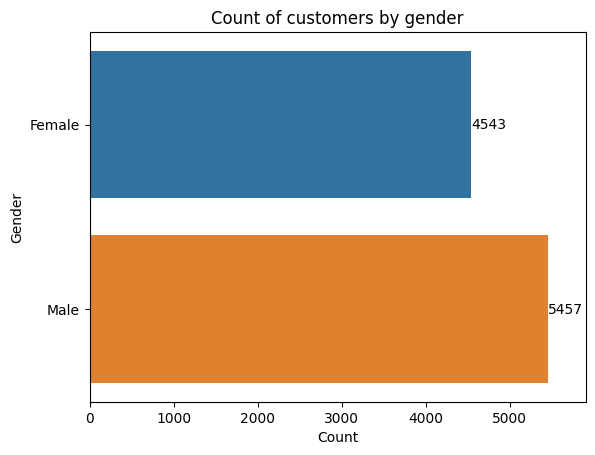

In [78]:
ax = sns.countplot(data= df, y= 'gender')
ax.set_title('Count of customers by gender')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Gender')
ax.set_xlabel('Count')
ax.set_xlim([0, 5.9e3]) # set the limit of x-axis.
plt.show()

> There are more male than female customers in the dataset.

### 5.1.2. Geography

**What is the distribution of the bank's customers in the countries?**

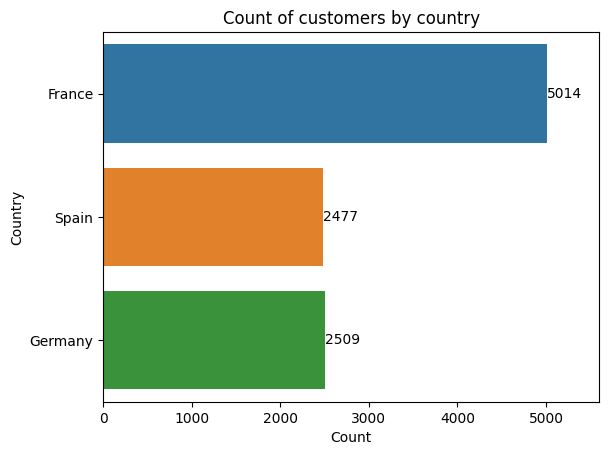

In [79]:
ax = sns.countplot(data= df, y= 'geography')
ax.set_title('Count of customers by country')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Country')
ax.set_xlabel('Count')
ax.set_xlim([0, 5.6e3]) # set the limit of x-axis.
plt.show()

> There are customer data from three countries: France, Spain and Germany. The majority are from France.

### 5.1.3. Card type

**What distribution of customers with each type of credit card offered by the bank?**

In [80]:
df['card_type'].unique()

array(['DIAMOND', 'GOLD', 'SILVER', 'PLATINUM'], dtype=object)

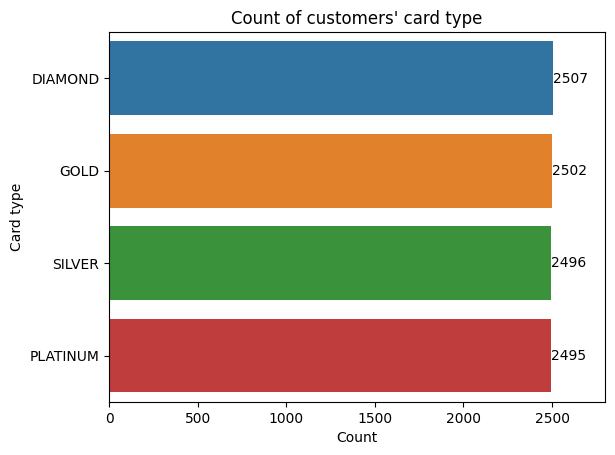

In [81]:
ax = sns.countplot(data= df, y= 'card_type')
ax.set_title("Count of customers' card type")

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Card type')
ax.set_xlabel('Count')
ax.set_xlim([0, 2.8e3]) # set the limit for x-axis.
plt.show()

> The distribution of card types is practically the same in the dataset.

### 5.1.4. Has credit card

**How many customers do or do not have a credit card?**

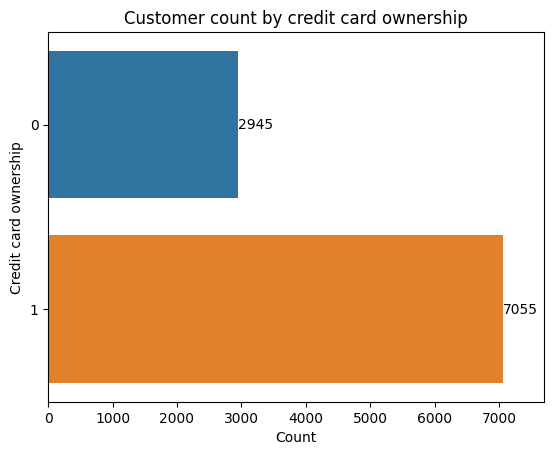

In [82]:
ax = sns.countplot(data= df, y= 'has_credit_card')
ax.set_title('Customer count by credit card ownership')

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_xlabel('Count')
ax.set_ylabel('Credit card ownership')
ax.set_xlim([0, 7.7e3]) # set the limit for x-axis.
plt.show()

> Most of the bank's customers, around 70.5%, have a credit card.

### 5.1.5. Is active member

**How many active customers does the bank have?**

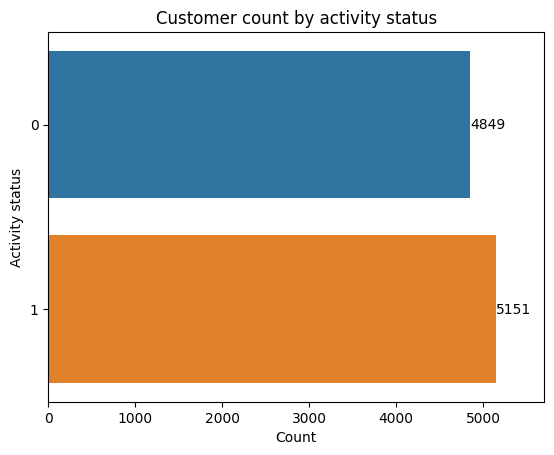

In [83]:
ax = sns.countplot(data= df, y= 'is_active_member')
ax.set_title('Customer count by activity status')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Activity status')
ax.set_xlabel('Count')
ax.set_xlim([0, 5.7e3]) # set the limit for x-axis.
plt.show()

> Most of the bank's customers are active, but the difference is not so expressive.

### 5.1.6. Complain

**How many customers expressed a complaint?**

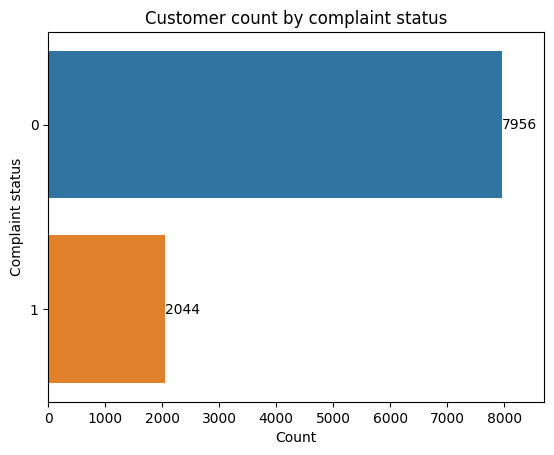

In [84]:
ax = sns.countplot(data= df, y= 'complain')
ax.set_title('Customer count by complaint status')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Complaint status')
ax.set_xlabel('Count')
ax.set_xlim([0, 8.7e3]) # set the limit for x-axis.
plt.show()

> Only 2044 customers filed a complaint, this corresponds to 20.44% of customers.

## 5.2. Numeric variables

In numerical variables, it is important to analyze mainly the data distribution and plot boxplots in order to identify the presence of outliers.

### 5.2.1. Frequency distribution of each numeric variable

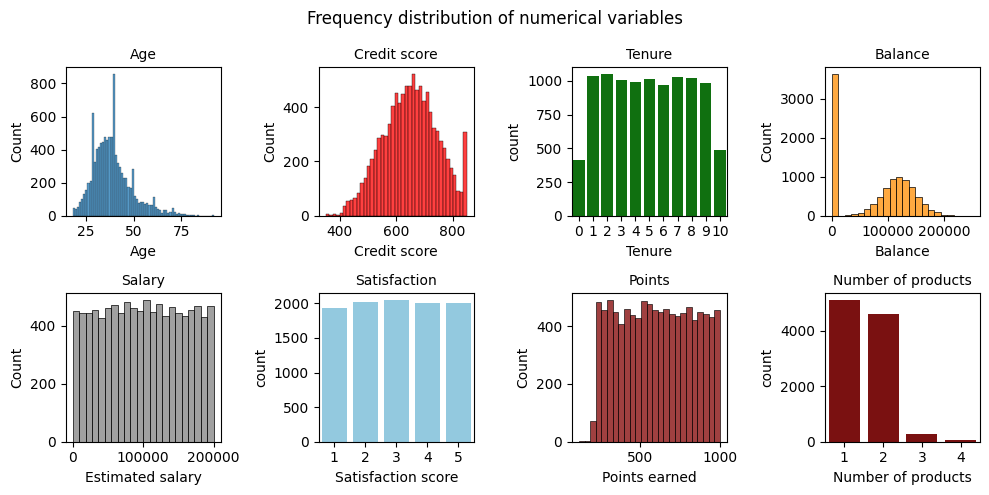

In [85]:
fig, ax = plt.subplots(2, 4, figsize= (10, 5))
fig.suptitle('Frequency distribution of numerical variables')

ax1 = sns.histplot(data= df, x= 'age', ax= ax[0, 0])
ax1.set_title('Age',fontsize= 10)
ax1.set_xlabel('Age')
ax2 = sns.histplot(data= df, x= 'credit_score', color= 'r', ax= ax[0, 1])
ax2.set_title('Credit score',fontsize= 10)
ax2.set_xlabel('Credit score')
ax3 = sns.countplot(data= df, x= 'tenure', color= 'g', ax= ax[0, 2])
ax3.set_title('Tenure',fontsize= 10)
ax3.set_xlabel('Tenure')
ax4 = sns.histplot(data= df, x= 'balance', color= 'darkorange', ax= ax[0, 3])
ax4.set_title('Balance',fontsize= 10)
ax4.set_xlabel('Balance')
ax5 = sns.histplot(data= df, x= 'estimated_salary', color= 'gray', ax= ax[1, 0])
ax5.set_title('Salary',fontsize= 10)
ax5.set_xlabel('Estimated salary')
ax6 = sns.countplot(data= df, x= 'satisfaction_score', color= 'skyblue', ax= ax[1, 1])
ax6.set_title('Satisfaction',fontsize= 10)
ax6.set_xlabel('Satisfaction score')
ax7 = sns.histplot(data= df, x= 'point_earned', color= 'maroon', ax= ax[1, 2])
ax7.set_title('Points',fontsize= 10)
ax7.set_xlabel('Points earned')
ax8 = sns.countplot(data= df, x= 'num_of_products', color= 'darkred', ax= ax[1, 3])
ax8.set_title('Number of products', fontsize= 10)
ax8.set_xlabel('Number of products')
plt.tight_layout()
plt.show()

> None of the numeric variables in the dataset follow a normal distribution.

### 5.2.2. Boxplot of each numeric variable

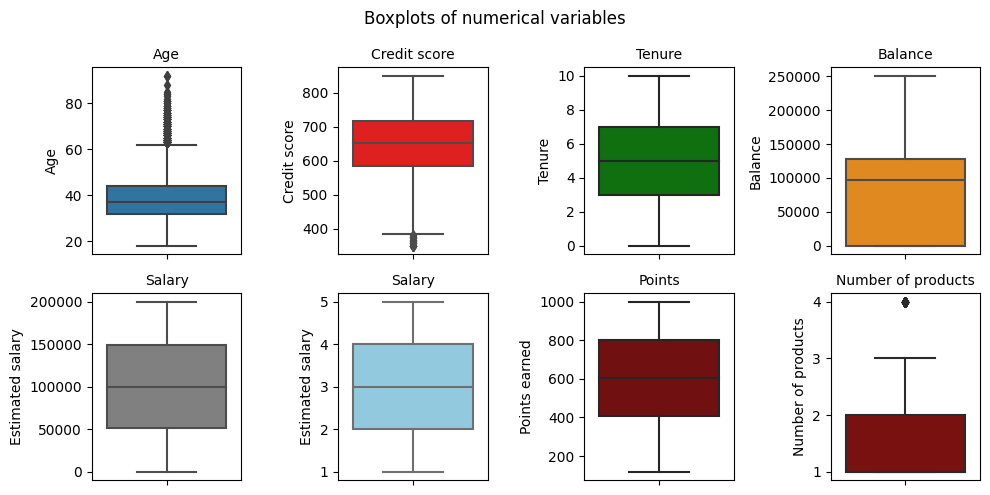

In [86]:
fig, ax = plt.subplots(2, 4, figsize= (10, 5))
fig.suptitle('Boxplots of numerical variables')

ax1 = sns.boxplot(data= df, y= 'age', ax= ax[0, 0])
ax1.set_title('Age',fontsize= 10)
ax1.set_ylabel('Age')
ax2 = sns.boxplot(data= df, y= 'credit_score', color= 'r', ax= ax[0, 1])
ax2.set_title('Credit score',fontsize= 10)
ax2.set_ylabel('Credit score')
ax3 = sns.boxplot(data= df, y= 'tenure', color= 'g', ax= ax[0, 2])
ax3.set_title('Tenure', fontsize= 10)
ax3.set_ylabel('Tenure')
ax4 = sns.boxplot(data= df, y= 'balance', color= 'darkorange', ax= ax[0, 3])
ax4.set_title('Balance',fontsize= 10)
ax4.set_ylabel('Balance')
ax5 = sns.boxplot(data= df, y= 'estimated_salary', color= 'gray', ax= ax[1, 0])
ax5.set_title('Salary',fontsize= 10)
ax5.set_ylabel('Estimated salary')
ax6 = sns.boxplot(data= df, y= 'satisfaction_score', color= 'skyblue', ax= ax[1, 1])
ax6.set_title('Salary',fontsize= 10)
ax6.set_ylabel('Estimated salary')
ax7 = sns.boxplot(data= df, y= 'point_earned', color= 'maroon', ax= ax[1, 2])
ax7.set_title('Points',fontsize= 10)
ax7.set_ylabel('Points earned')
ax8 = sns.boxplot(data= df, y= 'num_of_products', color= 'darkred', ax= ax[1, 3])
ax8.set_title('Number of products', fontsize= 10)
ax8.set_ylabel('Number of products')
plt.tight_layout()
plt.show()

> * There are some outliers in the num_of_products and credit_score variables. Since they are few, there is no need to remove them.
>
> * In the age variable there is a greater number of outliers, however, as it makes sense for a bank to have several customers of different ages, these are certainly data that cannot be discarded. That is, they are statistically relevant.

# 5.3. Analysis of the profile of customers who leave the bank

### 5.3.1 Exited

**What is the distribution of customers among the exit status of customers?**

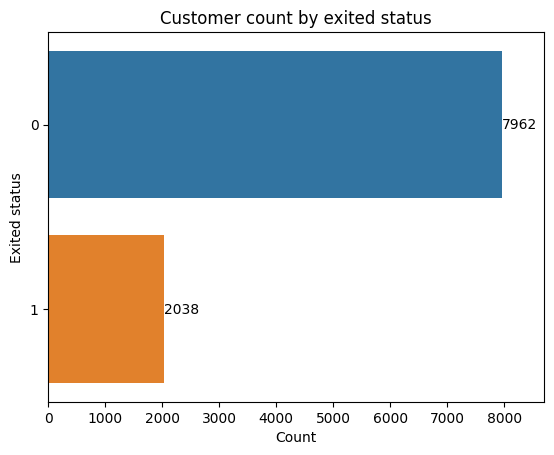

In [87]:
ax = sns.countplot(data= df, y= 'exited')
ax.set_title('Customer count by exited status')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Exited status')
ax.set_xlabel('Count')
ax.set_xlim([0, 8.7e3]) # set the limit for x-axis.
plt.show()

> Customers who closed their bank accounts accounted for 20.38% of those in the dataset.

### Who closes more bank accounts, men or women?

In [88]:
# Exited customers data:

exited_customers = df.query('exited == 1')

# Exited customers dataframe overview:

exited_customers.head(3)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_credit_card,is_active_member,estimated_salary,exited,complain,satisfaction_score,card_type,point_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,5,DIAMOND,484


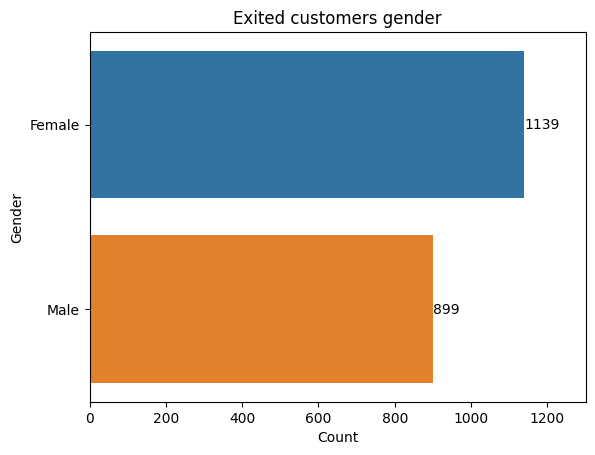

In [89]:
ax = sns.countplot(data= exited_customers, y= 'gender')
ax.set_title('Exited customers gender')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Gender')
ax.set_xlabel('Count')
ax.set_xlim([0, 1.3e3]) # set the limit for x-axis.
plt.show()

> Although there are fewer female customers in the dataset, they are the majority among customers who close their bank account.

### What is the age range of customers who close their accounts?

In [90]:
df.groupby('exited')['age'].agg(['mean', 'median', 'std']).round(2)

,mean,median,std
exited,,,
0,37.41,36.0,10.13
1,44.84,45.0,9.76


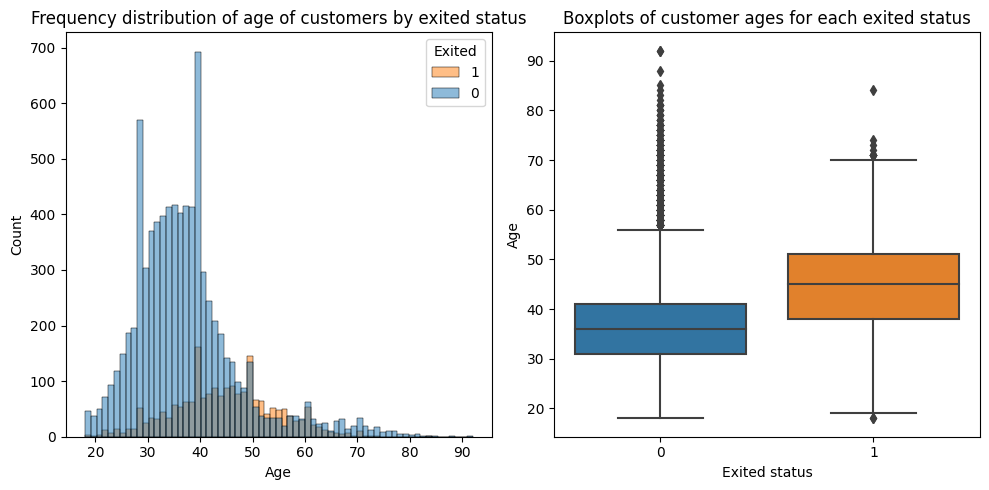

In [91]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))

ax1 = sns.histplot(data= df, x= 'age', hue= 'exited', ax= ax[0])
ax1.set_title('Frequency distribution of age of customers by exited status')
ax1.legend(title= 'Exited', labels= [1, 0])
ax1.set_xlabel('Age')
ax2 = sns.boxplot(data= df, y= 'age', x= 'exited', ax= ax[1])
ax2.set_title('Boxplots of customer ages for each exited status')
ax2.set_ylabel('Age')
ax2.set_xlabel('Exited status')
plt.tight_layout()
plt.show()

> It is possible to see that the age group of customers who close their accounts is more advanced, with a median age of 45 years.

### Where are the customers who close their accounts?

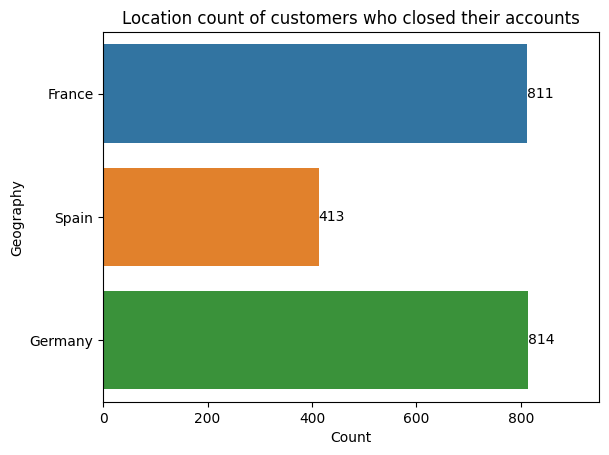

In [92]:
ax = sns.countplot(data= exited_customers, y= 'geography')
ax.set_title('Location count of customers who closed their accounts')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Geography')
ax.set_xlabel('Count')
ax.set_xlim([0, 9.5e2]) # set the limit for x-axis.
plt.show()

> France and Germany are the main locations among the clients that close their accounts the most, although most of the clients in the dataset are from France.

### Are members who close accounts active?

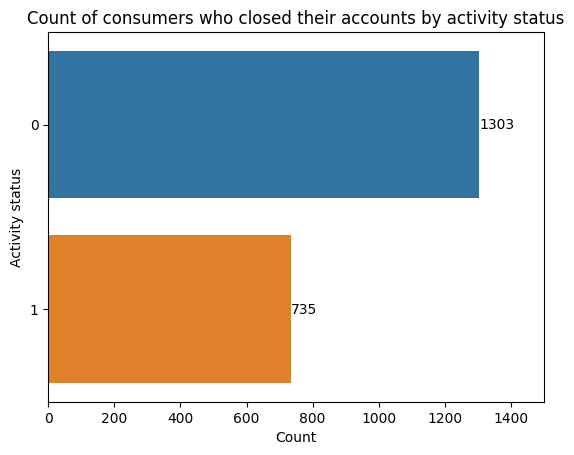

In [93]:
ax = sns.countplot(data= exited_customers, y= 'is_active_member')
ax.set_title('Count of consumers who closed their accounts by activity status')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Activity status')
ax.set_xlabel('Count')
ax.set_xlim([0, 1.5e3]) # set the limit for x-axis.
plt.show()

> Although non-active users are those who close accounts the most, of consumers who close their accounts, active users account for 36.04%.

### What is the estimated salary of those who close their account?

In [94]:
df.groupby('exited')['estimated_salary'].agg(['mean', 'median', 'std']).round(2)

,mean,median,std
exited,,,
0,99726.85,99620.36,57399.96
1,101509.91,102489.34,57932.62


> The earnings of customers who closed their bank accounts appear to be different from customers who remain with bank accounts.

However, are the distributions of these two samples statistically different?

In [95]:
# Samples:

still_customer = df.query('exited == 0')['estimated_salary']
exited_customer = df.query('exited == 1')['estimated_salary']

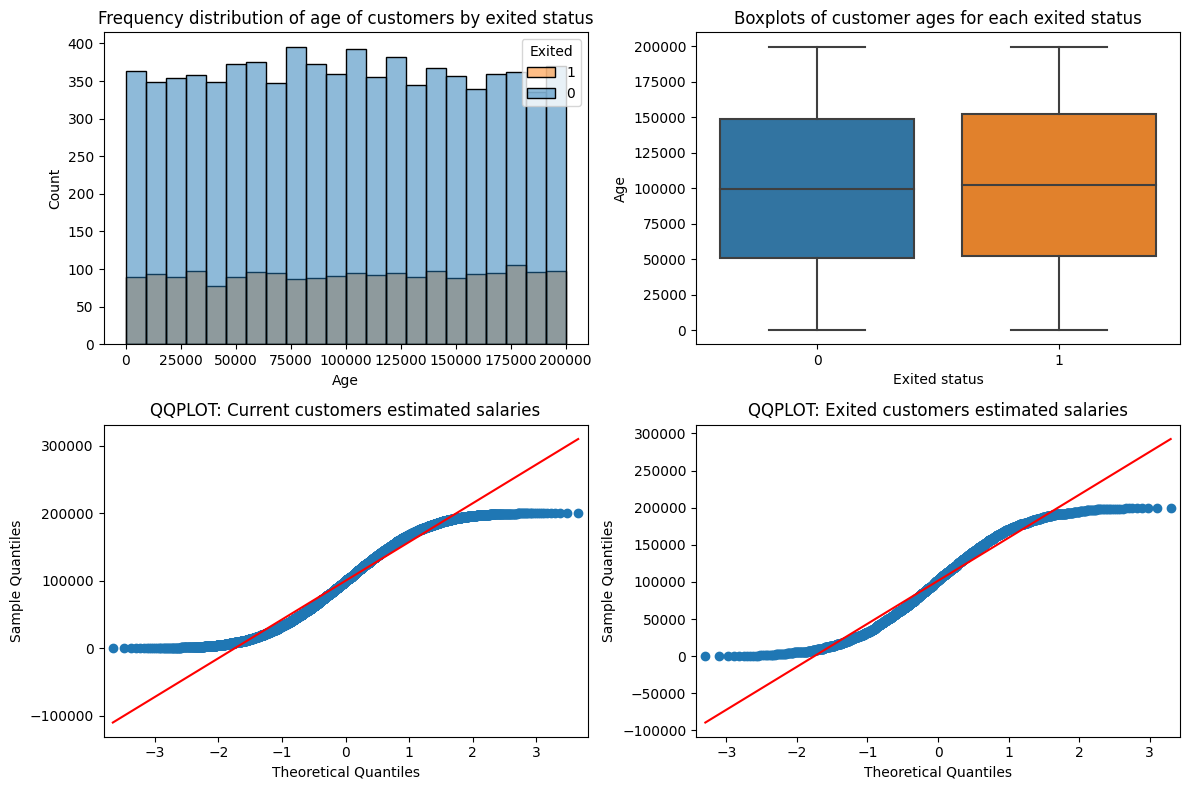

In [96]:
fig, ax = plt.subplots(2, 2, figsize= (12, 8))

ax1 = sns.histplot(data= df, x= 'estimated_salary', hue= 'exited', ax= ax[0, 0])
ax1.set_title('Frequency distribution of age of customers by exited status')
ax1.legend(title= 'Exited', labels= [1, 0])
ax1.set_xlabel('Age')
ax2 = sns.boxplot(data= df, y= 'estimated_salary', x= 'exited', ax= ax[0, 1])
ax2.set_title('Boxplots of customer ages for each exited status')
ax2.set_ylabel('Age')
ax2.set_xlabel('Exited status')
sm.qqplot(still_customer, line= 's', ax= ax[1, 0]) # qqplot of data from current customers salaries.
ax[1,0].set_title('QQPLOT: Current customers estimated salaries') # set the first qqplot's title.
sm.qqplot(exited_customer, line= 's', ax= ax[1, 1]) # qqplot of data from exited customers salaries.
ax[1, 1].set_title('QQPLOT: Exited customers estimated salaries') # set the second qqplot's title.
plt.tight_layout()
plt.show()

> Graphically, mainly through the histograms and QQplots, it is possible to notice that the data with the salary estimates of both samples **do not follow a normal distribution**.

Therefore, it is not appropriate to compare sample means, but their medians. In addition, it is appropriate to perform a non-parametric test, in this case the Mann-Whitney test, which compares the medians of the samples.

$Me_1 →$ Current customers estimated salaries median

$Me_2 →$ Exited customers estimated salaries median

> $H_0: Me_1 = Me_2$
>
> $H_1: Me_1 \neq Me_2$

In [97]:
stat, pvalue = mannwhitneyu(still_customer, exited_customer, alternative= 'two-sided')

In [98]:
print(f'Stat = {stat}')
print('='*30)
print(f'P-value = {pvalue}')

Stat = 7968250.0
P-value = 0.21235576456250627


$H_0$ hypothesis is rejected if $pvalue \leq α$.  Assuming that the significance level ($α$) is 5% (0.05):

In [99]:
pvalue <= 0.05

False

> There is no statistical evidence to reject the $H_0$ hypothesis. Therefore, the median salary of current customers and customers who have closed their accounts is assumed to be the same.

### Do complainers usually close their bank account?

In [100]:
complain_exited = pd.crosstab(df['complain'], df['exited'])

complain_exited

exited,0,1
complain,,
0,7952,4
1,10,2034


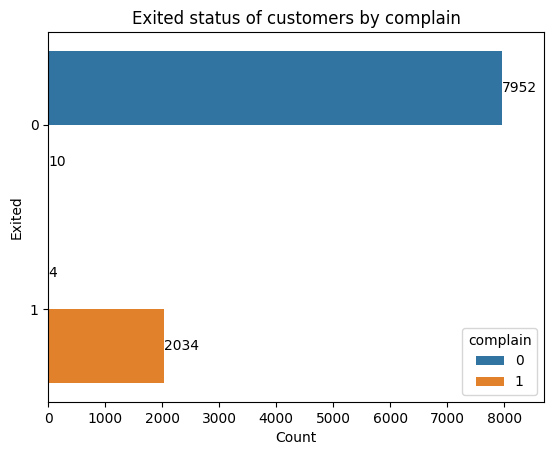

In [101]:
ax = sns.countplot(data= df, y= 'exited', hue= 'complain')
ax.set_title('Exited status of customers by complain')

# Set a label for each bar:

for container in ax.containers:
  ax.bar_label(container, label_type= 'edge')

ax.set_ylabel('Exited')
ax.set_xlabel('Count')
ax.set_xlim([0, 8.7e3]) # set the limit range of x-axis.
plt.show()

> Virtually all customers with complaints closed their accounts. Just as almost no customer without a complaint closed their account.

## 5.4. Correlation between the variables

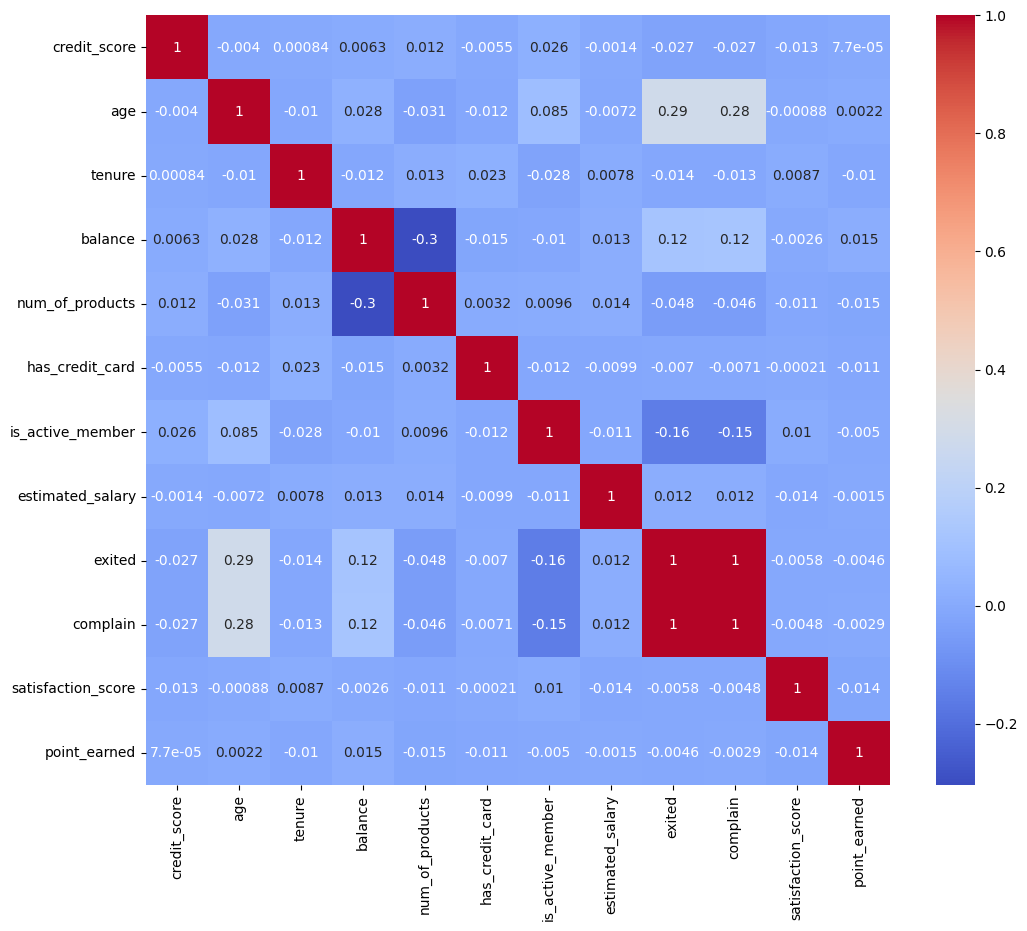

In [102]:
plt.figure(figsize= (12, 10))
sns.heatmap(data= df.corr(numeric_only=True), annot= True, cmap= 'coolwarm')
plt.show()

> **A perfect correlation** can be seen between the variable `complain` and the target variable. Therefore, this variable **will not be used** in the models that will be trained.

# 6. Using LGBM Regressor to predict churn


The LGBM Classifier is a gradient boosting-based machine learning algorithm that utilizes the LightGBM library. It is designed to handle classification problems, where the goal is to predict the class or category to which a given instance belongs.

The LGBM Classifier stands out for its efficiency and fast training speed, enabling it to handle large datasets efficiently. This is possible due to its tree structure, where the splits are optimized using the histogram-based splitting algorithm.

## 6.1. Splitting data

In [103]:
# Data with independent variables:

X = df.drop(['complain', 'exited'], axis= 1) # due to the perfect correlation between the variable complain and the target variable, complain is eliminated.

# Data from target variable:

y = df['exited']

Since the dataset is relatively small, it is important to perform some kind of cross-validation to ensure that the proposed model is robust across the entire dataset.

> **StratifiedShuffleSplit** is a cross-validation technique that is often used to evaluate machine learning models when dealing with imbalanced datasets or when one wants to preserve the distribution of classes during data splitting.

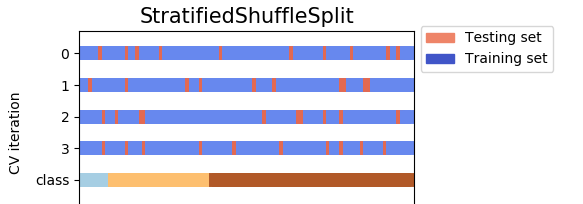

In [104]:
# The StratifiedShuffleSplit is instancied with 5 splits, and test size of 20%:

sss = StratifiedShuffleSplit(n_splits= 5, test_size= 0.2, random_state= RANDOM_SEED)

In [105]:
sss.get_n_splits(X, y)

5

In [106]:
sss

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)

## 6.2. Data pipeline

* Pre-processing of nominal categorical variables:
> Nominal categorical variables (`geography`, `gender`, `card_type`) will be processed with OneHotEncoder. Since variables don't have as many unique values, the "curse of dimensionality" won't happen.

* Numerical variables scaling with *MinMaxScaler*:
> As numerical data have different scales, it is important to perform some scaling of the data. **Since the data do not follow a normal distribution**, it is more appropriate to use **MinMaxScaler**.
> 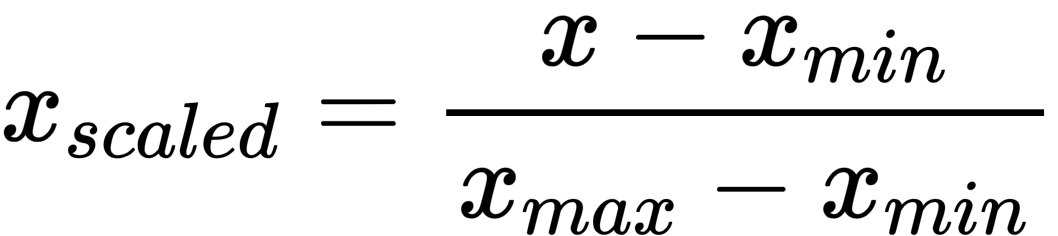
>
>
> When using this technique the data will assume values ​​between 0 and 1.

In [107]:
# Specification of the columns that will be preprocessed:

categorical_columns = ['geography', 'gender', 'card_type']
numerical_columns = ['credit_score', 'age', 'balance', 'num_of_products', 'estimated_salary', 'satisfaction_score', 'point_earned']

In [108]:
# Using the Column Transformer to pre-process categorical and numeric data:

preprocessing = ColumnTransformer(
    transformers= [
        ('categorical', OneHotEncoder(drop_invariant= True), categorical_columns),
        ('numerical', MinMaxScaler(), numerical_columns)
    ]
)

> *ColumnTransformer* makes data preprocessing easy, especially when you have a dataset that includes numeric columns, categorical columns, and other characteristics with different transformation needs.

In [109]:
# The pipeline is instantiated with two steps (pre-processing and data modeling):

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', LGBMClassifier(random_state= RANDOM_SEED))
])

In [110]:
# Parameter ranges that will be optimized by BayesSearchCV:

parameters_grid = {
    'classifier__max_depth': [i for i in range(1, 9)],
    'classifier__num_leaves': [i for i in range(20, 51)],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'classifier__n_estimators': [i for i in range(50, 500, 50)],
    'classifier__min_child_samples': [i for i in range(20, 50, 5)],
    'classifier__is_unbalance': [False, True],
    'classifier__subsample': [0.5, 0.8, 1],
    'classifier__subsample_freq': [1, 2, 3],
    # 'classifier__scale_pos_weight': [positive_ratio, 1]
}

## 6.3. Use of *RandomizedSearchCV* to tune the hyperparameters of the model

RandomizedSearchCV is a technique used for hyperparameter tuning in machine learning models. It is a variant of grid search where instead of exhaustively searching all possible hyperparameter combinations, it randomly samples a specified number of parameter settings from a given distribution.

The purpose of RandomizedSearchCV is to efficiently explore a wide range of hyperparameter values and find the optimal combination that maximizes the model's performance. By randomly selecting parameter values, it avoids the computational cost of evaluating all possible combinations.

In [111]:
# Instance of RandomSearchCV object:

random_search = RandomizedSearchCV(pipeline, parameters_grid, cv= 5, scoring= 'f1', random_state= RANDOM_SEED, n_jobs= 1)

> As the objective of the model is to predict the churn of bank employees, **avoiding false positives and false negatives is essential**. Therefore, **F1-Score** is chosen as the parameter passed to scoring. A good F1-Score value indicates a good balance between Precision and Recall.

## 6.4. Metrics scores for different folds

In [112]:
# Dictionaries in which the scores obtained in each fold will be stored:

scores_test = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

i = 0

for train_index, test_index in sss.split(X, y):
  i += 1

  # The training and testing indices are passed:

  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  print(f'Fold number = {i}')
  print('--' * 20)

  random_search.fit(X_train, y_train)
  print(random_search.best_params_)

  print('==' * 20)
  y_pred_test = random_search.predict(X_test)
  y_pred_train = random_search.predict(X_train)

  # Scores:

  scores_test['accuracy'].append(accuracy_score(y_test, y_pred_test))
  scores_test['precision'].append(precision_score(y_test, y_pred_test))
  scores_test['recall'].append(recall_score(y_test, y_pred_test))
  scores_test['f1'].append(f1_score(y_test, y_pred_test))
  scores_test['auc'].append(roc_auc_score(y_test, random_search.predict_proba(X_test)[::, 1])) # to determine the AUC score the probabilities must be passed.

Fold number = 1
----------------------------------------
{'classifier__subsample_freq': 2, 'classifier__subsample': 1, 'classifier__num_leaves': 37, 'classifier__n_estimators': 150, 'classifier__min_child_samples': 35, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__is_unbalance': True}
Fold number = 2
----------------------------------------
{'classifier__subsample_freq': 2, 'classifier__subsample': 1, 'classifier__num_leaves': 37, 'classifier__n_estimators': 150, 'classifier__min_child_samples': 35, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__is_unbalance': True}
Fold number = 3
----------------------------------------
{'classifier__subsample_freq': 2, 'classifier__subsample': 1, 'classifier__num_leaves': 37, 'classifier__n_estimators': 150, 'classifier__min_child_samples': 35, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__is_unbalance': True}
Fold number = 4
------------------------------------

The calculated metrics (accuracy, precision, recall, F1-score and AUC) are instantiated in dataframe.

In [113]:
# Dataframes with scores obtained from training and testing data are instantiated:

scores = pd.DataFrame(scores_test, index= ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']).transpose()


In [114]:
pd.DataFrame({'Mean': scores.transpose().mean(), 'Standard Deviation': scores.transpose().std()})

,Mean,Standard Deviation
accuracy,0.815600,0.007021
precision,0.537660,0.015420
recall,0.693627,0.016165
f1,0.605539,0.008981
auc,0.850234,0.006115


> The table shows the averages obtained for the metrics of each fold. In addition, it shows a low standard deviation between scores, which indicates good model robustness.

The scores for each fold can be viewed below:

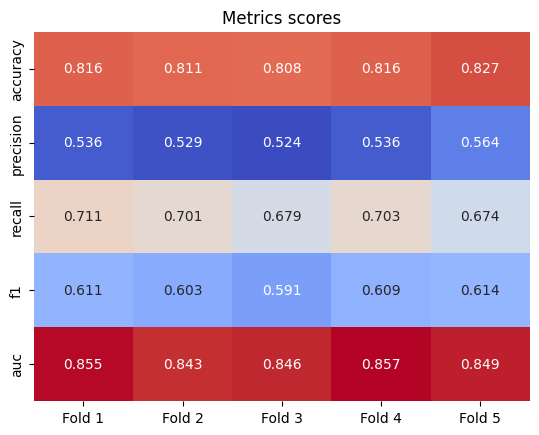

In [115]:
ax = sns.heatmap(data= scores, annot= True, cbar= False, cmap= 'coolwarm', fmt= '.3f')
ax.set_title('Metrics scores')
plt.show()

# 7. Conclusion

On this notebook:

> * Some pre-processing was done to better work with dataset data.
> * An exploratory analysis of the data was carried out to better understand the data and behavior of users who closed their bank accounts.
> * Using a pipeline to organize preprocessing on variables (OneHotEncoding and normalization).
> * Hyperparameter tuning with RandomSearchCV.
> * Evaluation of the model with the main metrics in order to indicate its robustness.